In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)

# Configuração opcional de display
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")


In [22]:
# Depois de fazer upload manual do ds_salaries.csv no Colab:
df = pd.read_csv("ds_salaries.csv")
df.head()


,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [23]:
# Visão geral
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [24]:
# Estatísticas numéricas básicas
df.describe()


,Unnamed: 0,work_year,salary,salary_in_usd,remote_ratio
count,607.00,607.00,607.00,607.00,607.00
mean,303.00,"2,021.41","324,000.06","112,297.87",70.92
std,175.37,0.69,"1,544,357.49","70,957.26",40.71
min,0.00,"2,020.00","4,000.00","2,859.00",0.00
25%,151.50,"2,021.00","70,000.00","62,726.00",50.00
50%,303.00,"2,022.00","115,000.00","101,570.00",100.00
75%,454.50,"2,022.00","165,000.00","150,000.00",100.00
max,606.00,"2,022.00","30,400,000.00","600,000.00",100.00


In [25]:
# Ver se há nulos
df.isna().sum()


Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

## Parte 1 – Análise Exploratória (EDA)

### 1. Estatísticas gerais de `salary_in_usd`

In [26]:
target = "salary_in_usd"

salary_mean = df[target].mean()
salary_median = df[target].median()
salary_std = df[target].std()

print(f"Média:        {salary_mean:,.2f}")
print(f"Mediana:      {salary_median:,.2f}")
print(f"Desvio-padrão:{salary_std:,.2f}")


Média:        112,297.87
Mediana:      101,570.00
Desvio-padrão:70,957.26


- Quantidade de registros: **607**
- Salário médio (USD): **≈ 112.300**
- Mediana (USD): **≈ 101.570**
- Desvio-padrão (USD): **≈ 70.960**
- Mínimo: **2.859**
- Máximo: **600.000**

A diferença grande entre média e mediana, junto com o desvio-padrão alto, indica
uma distribuição bem assimétrica, puxada por poucos salários muito altos no topo.

### 2. Distribuição das variáveis categóricas

In [27]:
cat_cols = ["experience_level", "employment_type", "company_size"]

for col in cat_cols:
    dist = (df[col].value_counts(normalize=True) * 100).round(2)
    print(f"\nDistribuição percentual de {dist}")
    



Distribuição percentual de experience_level
SE   46.13
MI   35.09
EN   14.50
EX    4.28
Name: proportion, dtype: float64

Distribuição percentual de employment_type
FT   96.87
PT    1.65
CT    0.82
FL    0.66
Name: proportion, dtype: float64

Distribuição percentual de company_size
M   53.71
L   32.62
S   13.67
Name: proportion, dtype: float64


**Nível de experiência (`experience_level`):**

- **SE (Senior)**: **46,13%**
- **MI (Mid)**: **35,09%**
- **EN (Entry)**: **14,50%**
- **EX (Executive)**: **4,28%**

Ou seja, a base é dominada por profissionais de nível **sênior e pleno**, com
poucos executivos e uma parcela menor de iniciantes.

**Tipo de contrato (`employment_type`):**

- **FT (Full-time)**: **96,87%**
- **PT (Part-time)**: **1,65%**
- **CT (Contractor)**: **0,82%**
- **FL (Freelancer)**: **0,66%**

Quase todos os registros são de **trabalho em tempo integral**, então os demais tipos
aparecem bem pouco e exigem cuidado na interpretação.

**Tamanho da empresa (`company_size`):**

- **M (Medium)**: **53,71%**
- **L (Large)**: **32,62%**
- **S (Small)**: **13,67%**

Predominam empresas **médias e grandes**, com menor participação de empresas pequenas.

### 3. Top 5 cargos por média salarial

In [28]:
target = "salary_in_usd"

mean_salary_by_job = (
    df.groupby("job_title")[target]
      .mean()
      .sort_values(ascending=False)
)

top5_jobs = mean_salary_by_job.head(5)

print("Top 5 cargos por média salarial (USD):")
print(top5_jobs)


Top 5 cargos por média salarial (USD):
job_title
Data Analytics Lead        405,000.00
Principal Data Engineer    328,333.33
Financial Data Analyst     275,000.00
Principal Data Scientist   215,242.43
Director of Data Science   195,074.00
Name: salary_in_usd, dtype: float64


Top 5 cargos (`job_title`) com maior **média de `salary_in_usd`**:

1. **Data Analytics Lead** – ≈ **405.000 USD**
2. **Principal Data Engineer** – ≈ **328.333 USD**
3. **Financial Data Analyst** – ≈ **275.000 USD**
4. **Principal Data Scientist** – ≈ **215.242 USD**
5. **Director of Data Science** – ≈ **195.074 USD**

Os cargos mais bem pagos misturam posições **de liderança técnica** (Principal / Lead)
com **cargos de direção** focados em Data Science.

### 4. Correlação entre `remote_ratio`, `company_size` e `salary_in_usd`

Matriz de correlação:
                  remote_ratio  company_size_num  salary_in_usd
remote_ratio              1.00             -0.02           0.13
company_size_num         -0.02              1.00           0.15
salary_in_usd             0.13              0.15           1.00


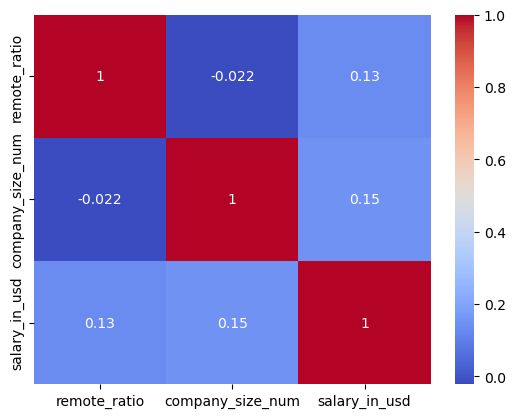

In [29]:
# Mapear company_size para número
size_map = {"S": 1, "M": 2, "L": 3}
df["company_size_num"] = df["company_size"].map(size_map)

corr_cols = ["remote_ratio", "company_size_num", "salary_in_usd"]
corr = df[corr_cols].corr()

print("Matriz de correlação:")
print(corr)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


Para permitir o cálculo de correlação com `company_size`, codificamos:

- S → 1  
- M → 2  
- L → 3  

Matriz de correlação (Pearson):

- `remote_ratio` × `salary_in_usd` → **≈ 0,13**
- `company_size_num` × `salary_in_usd` → **≈ 0,15**
- `remote_ratio` × `company_size_num` → **≈ -0,02**

Logo:

- A relação entre **trabalho remoto e salário** é **positiva, porém muito fraca**.
- O **porte da empresa** também tem correlação **positiva fraca** com salário.
- **Tamanho da empresa e percentual remoto** são praticamente independentes.

Isso indica que **nem o remoto, nem o tamanho explicam sozinhos o salário**;
outros fatores (cargo, localização, senioridade) pesam bem mais.

### 5. Boxplots de salário por experiência e localização

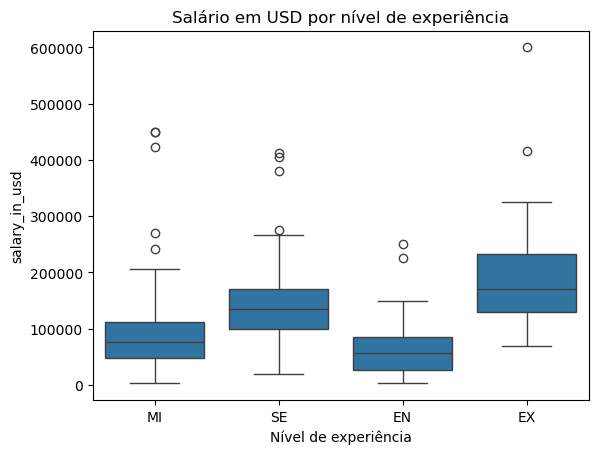

In [30]:
sns.boxplot(data=df, x="experience_level", y="salary_in_usd")
plt.title("Salário em USD por nível de experiência")
plt.xlabel("Nível de experiência")
plt.ylabel("salary_in_usd")
plt.show()

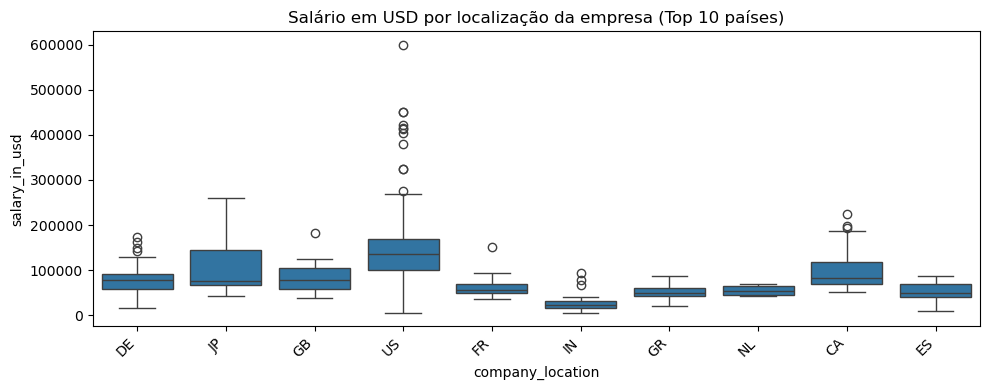

In [31]:
df["company_location"].value_counts().head(10)
top_countries = df["company_location"].value_counts().head(10).index
df_top = df[df["company_location"].isin(top_countries)]

plt.figure(figsize=(10, 4))
sns.boxplot(data=df_top, x="company_location", y="salary_in_usd")
plt.title("Salário em USD por localização da empresa (Top 10 países)")
plt.xlabel("company_location")
plt.ylabel("salary_in_usd")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Os boxplots mostram que:

- **Por nível de experiência (`experience_level`):**
  - **EX (Executive)** tem as maiores medianas e o maior espalhamento (muitos outliers),
    seguido por **SE (Senior)**.
  - **EN (Entry)** concentra salários mais baixos, com mediana bem abaixo de MI/SE/EX.
- **Por localização da empresa (`company_location`, top 10 em quantidade):**
  - Entre os países com mais registros, a **média de salário** em USD é aproximadamente:

    - **US**: ~144k  
    - **JP**: ~114k  
    - **CA**: ~99k  
    - **DE / GB**: ~82k  
    - **FR / NL / ES / GR**: ~52–64k  
    - **IN**: ~29k  

  - Países desenvolvidos como **Estados Unidos, Japão e Canadá** aparecem com
    salários médios mais altos, enquanto **Índia** (e, olhando o dataset completo,
    países como **Brasil, Vietnã, Irã**) têm salários médios bem menores.

## Perguntas Executivas – Parte 1

### 1) Como se comportam média e desvio-padrão de `salary_in_usd` em cada nível de experiência?

In [32]:
exp_stats = (
    df.groupby("experience_level")["salary_in_usd"]
      .agg(["count", "mean", "std"])
      .round(2)
)
exp_stats


,count,mean,std
experience_level,,,
EN,88,"61,643.32","44,395.54"
EX,26,"199,392.04","117,071.26"
MI,213,"87,996.06","63,901.06"
SE,280,"138,617.29","57,691.98"


Estatísticas por `experience_level`:

- **EN (Entry)**  
  - Média ≈ **61.643 USD**  
  - Desvio-padrão ≈ **44.396 USD**
- **MI (Mid)**  
  - Média ≈ **87.996 USD**  
  - Desvio-padrão ≈ **63.901 USD**
- **SE (Senior)**  
  - Média ≈ **138.617 USD**  
  - Desvio-padrão ≈ **57.692 USD**
- **EX (Executive)**  
  - Média ≈ **199.392 USD**  
  - Desvio-padrão ≈ **117.071 USD**

Há uma **progressão clara de salário conforme o nível de experiência aumenta**.
O grupo **EX** tem a **maior média** e também o **maior desvio-padrão**, indicando
que posições executivas podem variar muito em remuneração (bônus, stock options,
porte da empresa, região etc.).  
Mesmo em níveis mais baixos (EN e MI) o desvio-padrão é relevante, sugerindo que
o salário de iniciantes e plenos também depende bastante de cargo, país e empresa.


### 2) Qual tipo de contrato está associado às maiores médias salariais?  
Isso muda quando olhamos o porte da empresa?

In [33]:
emp_stats = (
    df.groupby("employment_type")["salary_in_usd"]
      .agg(["count", "mean"])
      .round(2)
)
emp_stats


,count,mean
employment_type,,
CT,5,"184,575.00"
FL,4,"48,000.00"
FT,588,"113,468.07"
PT,10,"33,070.50"


In [34]:
df_ft = df[df["employment_type"] == "FT"]

ft_size_stats = (
    df_ft.groupby("company_size")["salary_in_usd"]
         .agg(["count", "mean"])
         .round(2)
)
ft_size_stats


,count,mean
company_size,,
L,193,"119,665.36"
M,318,"118,662.09"
S,77,"76,484.00"



Médias de `salary_in_usd` por `employment_type`:

- **CT (Contractor)** – ≈ **184.575 USD** (apenas 5 registros)  
- **FL (Freelancer)** – ≈ **48.000 USD** (4 registros)  
- **FT (Full-time)** – ≈ **113.468 USD** (588 registros)  
- **PT (Part-time)** – ≈ **33.071 USD** (10 registros)

Isoladamente, **Contractor (CT)** aparece com maior média,
mas esse grupo é **muito pequeno** e sujeito a distorção por poucos salários extremos.

Olhando apenas **Full-time (FT)** por porte:

- FT em empresa **L (grande)** – média ≈ **119.665 USD**  
- FT em empresa **M (média)** – média ≈ **118.662 USD**  
- FT em empresa **S (pequena)** – média ≈ **76.484 USD**

Ou seja:

- Para contratos FT, **empresas médias e grandes pagam bem mais que empresas pequenas**.  
- Tipos de contrato alternativos (CT, FL, PT) são minoria na base, então as conclusões
  sobre eles devem ser feitas com cautela.

### 3) Como variam os salários médios entre países?  
Quais parecem pagar mais / menos?

In [35]:
country_stats = (
    df.groupby("company_location")["salary_in_usd"]
      .agg(["count", "mean"])
      .sort_values("count", ascending=False)
      .round(2)
)
country_stats.head(15)


,count,mean
company_location,,
US,355,"144,055.26"
GB,47,"81,583.04"
CA,30,"99,823.73"
DE,28,"81,887.21"
IN,24,"28,581.75"
FR,15,"63,970.67"
ES,14,"53,060.14"
GR,11,"52,293.09"
JP,6,"114,127.33"


Entre os países com mais registros:

- **Estados Unidos (US)** têm a maior média entre os top 10 em quantidade,
  com salário médio em torno de **144k USD**.
- **Japão (JP)** e **Canadá (CA)** também apresentam médias altas, na faixa
  de **100k–115k USD**.
- Países europeus como **Alemanha (DE)** e **Reino Unido (GB)** ficam na casa
  de **~82k USD** em média.
- **França (FR), Holanda (NL), Espanha (ES) e Grécia (GR)** aparecem com médias
  intermediárias (~52–64k USD).
- **Índia (IN)** tem média bem mais baixa, em torno de **28k USD**.

### 4) Existe relação entre trabalho remoto (`remote_ratio`) e salário?

In [36]:
remote_stats = (
    df.groupby("remote_ratio")["salary_in_usd"]
      .agg(["count", "mean", "median"])
      .round(2)
)
remote_stats

,count,mean,median
remote_ratio,,,
0,127,"106,354.62","99,000.00"
50,99,"80,823.03","69,999.00"
100,381,"122,457.45","115,000.00"



Agrupando por `remote_ratio`:

- **0% remoto (presencial)**  
  - Média ≈ **106.355 USD**  
  - Mediana ≈ **99.000 USD**
- **50% remoto (híbrido)**  
  - Média ≈ **80.823 USD**  
  - Mediana ≈ **70.000 USD**
- **100% remoto**  
  - Média ≈ **122.457 USD**  
  - Mediana ≈ **115.000 USD**

Além disso, a correlação entre `remote_ratio` e `salary_in_usd` é **≈ 0,13**,
uma correlação **positiva, porém fraca**.

Em resumo:

- Profissionais **100% remotos** tendem a ter **média e mediana salariais maiores**.
- Porém, a correlação baixa indica que o **fato de ser remoto não é, sozinho,
  o principal fator de salário**.  
  É provável que o remoto esteja associado a outros fatores (ex.: empresas globais,
  cargos mais avançados, senioridade maior), que também elevam salários.

### 5) O que podemos concluir sobre os cargos mais bem pagos?
Os 5 cargos com maior média salarial são:

1. **Data Analytics Lead**
2. **Principal Data Engineer**
3. **Financial Data Analyst**
4. **Principal Data Scientist**
5. **Director of Data Science**

Conclusões:

- São, em geral, **posições de liderança ou nível principal** (Principal, Lead, Director),
  o que indica forte prêmio salarial para quem assume responsabilidades estratégicas e técnicas.
- Há foco em cargos ligados a **engenharia de dados** e **data science avançado**,
  reforçando o valor de profissionais que conseguem tanto **construir infraestrutura de dados**
  quanto **gerar impacto de negócio** com modelos e análises.
- Cargos mais “generalistas” ou de entrada (por exemplo, *Data Analyst* em nível
  não sênior) tendem a ficar fora desse grupo de topo salarial.


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Variável alvo e preditora simples
X_simple = df[["remote_ratio"]]
y_simple = df["salary_in_usd"]

# Treino / teste
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_simple, y_simple, test_size=0.2, random_state=42
)

# Modelo de regressão linear
lin_reg_simple = LinearRegression()
lin_reg_simple.fit(X_train_s, y_train_s)

# Predição no conjunto de teste
y_pred_s = lin_reg_simple.predict(X_test_s)

# Métricas
r2_s = r2_score(y_test_s, y_pred_s)
rmse_s = mean_squared_error(y_test_s, y_pred_s, squared=False)
mae_s = mean_absolute_error(y_test_s, y_pred_s)

print("=== Regressão Linear Simples: salary_in_usd ~ remote_ratio ===")
print(f"Intercepto: {lin_reg_simple.intercept_:.2f}")
print(f"Coeficiente (remote_ratio): {lin_reg_simple.coef_[0]:.2f}")
print(f"R²: {r2_s:.4f}")
print(f"RMSE: {rmse_s:.2f}")
print(f"MAE: {mae_s:.2f}")


=== Regressão Linear Simples: salary_in_usd ~ remote_ratio ===
Intercepto: 101436.28
Coeficiente (remote_ratio): 179.58
R²: 0.0298
RMSE: 60977.35
MAE: 45611.66


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:

# Features numéricas e categóricas
numeric_features = ["work_year", "remote_ratio"]
categorical_features = [
    "experience_level",
    "employment_type",
    "job_title",
    "employee_residence",
    "company_location",
    "company_size",
]

X = df[numeric_features + categorical_features]
y = df["salary_in_usd"]

# Pré-processamento
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Pipeline: preprocessamento + modelo linear
lin_reg_multi = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

# Train/test split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Treinar
lin_reg_multi.fit(X_train_m, y_train_m)

# Prever
y_pred_m = lin_reg_multi.predict(X_test_m)

# Métricas
r2_m = r2_score(y_test_m, y_pred_m)
rmse_m = mean_squared_error(y_test_m, y_pred_m, squared=False)
mae_m = mean_absolute_error(y_test_m, y_pred_m)

print("=== Regressão Linear Múltipla ===")
print(f"R²:   {r2_m:.4f}")
print(f"RMSE: {rmse_m:.2f}")
print(f"MAE:  {mae_m:.2f}")

=== Regressão Linear Múltipla ===
R²:   0.0973
RMSE: 58818.78
MAE:  36567.49


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
import numpy as np
import pandas as pd

# Recuperar o OneHotEncoder usado no pipeline
ohe = lin_reg_multi.named_steps["preprocess"].named_transformers_["cat"]

# Nomes das colunas categóricas depois do one-hot
cat_cols = ohe.get_feature_names_out(categorical_features)

# Todas as features no mesmo array: numéricas + categóricas dummificadas
all_features = np.concatenate([numeric_features, cat_cols])

# Coeficientes do modelo linear
coefs = lin_reg_multi.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "feature": all_features,
    "coef": coefs
})

# Ordenar por valor absoluto do coeficiente (impacto)
coef_df_sorted = coef_df.reindex(
    coef_df["coef"].abs().sort_values(ascending=False).index
)

# Ver o top 20
coef_df_sorted.head(20)


,feature,coef
13,job_title_Applied Machine Learning Scientist,"268,136.02"
121,company_location_GB,"264,057.05"
104,employee_residence_VN,"-263,586.41"
23,job_title_Data Analytics Lead,"236,696.91"
74,employee_residence_GB,"-224,706.61"
100,employee_residence_TN,"-224,435.00"
62,employee_residence_BO,"-221,348.76"
76,employee_residence_HK,"-217,772.21"
130,company_location_IT,"178,900.75"
94,employee_residence_PL,"-176,919.42"


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)

# Criar variável binária de alto salário (acima da média)
salary_mean = df["salary_in_usd"].mean()
df["high_salary"] = (df["salary_in_usd"] > salary_mean).astype(int)

# Features e alvo para classificação
X_clf = df[numeric_features + categorical_features]
y_clf = df["high_salary"]

# Train/test split (estratificado)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Pipeline: mesmo preprocess + regressão logística
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

# Treinar
log_reg.fit(X_train_c, y_train_c)

# Predições
y_pred_c = log_reg.predict(X_test_c)
y_proba_c = log_reg.predict_proba(X_test_c)[:, 1]

# Métricas
acc  = accuracy_score(y_test_c, y_pred_c)
prec = precision_score(y_test_c, y_pred_c)
rec  = recall_score(y_test_c, y_pred_c)
f1   = f1_score(y_test_c, y_pred_c)

fpr, tpr, thresholds = roc_curve(y_test_c, y_proba_c)
roc_auc = auc(fpr, tpr)

print("=== Regressão Logística: high_salary (acima da média) ===")
print(f"Acurácia:  {acc:.4f}")
print(f"Precisão:  {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC ROC:   {roc_auc:.4f}")


=== Regressão Logística: high_salary (acima da média) ===
Acurácia:  0.8033
Precisão:  0.7679
Recall:    0.7963
F1-score:  0.7818
AUC ROC:   0.8957


In [42]:
# Analisar coeficientes e odds ratios do modelo logístico

preprocess_log = log_reg.named_steps["preprocess"]
ohe_log = preprocess_log.named_transformers_["cat"]

cat_cols_log = ohe_log.get_feature_names_out(categorical_features)
all_features_log = np.concatenate([numeric_features, cat_cols_log])

log_model = log_reg.named_steps["model"]
coefs_log = log_model.coef_.flatten()

odds_ratios = np.exp(coefs_log)

odds_df = pd.DataFrame({
    "feature": all_features_log,
    "coef": coefs_log,
    "odds_ratio": odds_ratios
})

# Ordenar por odds_ratio
odds_df_sorted = odds_df.sort_values("odds_ratio", ascending=False)

# Top 20 variáveis que mais aumentam a chance de high_salary
print("=== Top 20 odds_ratio (maiores que 1) ===")
display(odds_df_sorted.head(20))

# Bottom 20 variáveis (odds_ratio mais próximos de 0, reduzem chance)
print("=== Bottom 20 odds_ratio (menores que 1) ===")
display(odds_df_sorted.tail(20))


=== Top 20 odds_ratio (maiores que 1) ===


,feature,coef,odds_ratio
108,employee_residence_US,1.60,4.95
153,company_location_US,1.48,4.39
3,experience_level_EX,1.39,4.03
50,job_title_Machine Learning Scientist,1.11,3.04
34,job_title_Director of Data Science,1.03,2.81
54,job_title_Principal Data Scientist,0.92,2.52
134,company_location_IL,0.78,2.19
43,job_title_Lead Data Scientist,0.70,2.02
67,employee_residence_CH,0.70,2.01
8,employment_type_FT,0.69,1.99


=== Bottom 20 odds_ratio (menores que 1) ===


,feature,coef,odds_ratio
103,employee_residence_RU,-0.39,0.68
7,employment_type_FL,-0.39,0.67
39,job_title_Head of Data Science,-0.41,0.67
41,job_title_Lead Data Analyst,-0.41,0.66
46,job_title_Machine Learning Developer,-0.42,0.66
13,job_title_Applied Machine Learning Scientist,-0.43,0.65
14,job_title_BI Data Analyst,-0.44,0.65
16,job_title_Big Data Engineer,-0.47,0.63
157,company_size_S,-0.58,0.56
126,company_location_ES,-0.59,0.55


## Perguntas Executivas – Parte 1


### 6) Quais variáveis explicam melhor as diferenças salariais segundo a regressão linear? O modelo apresenta um R² satisfatório para explicar o comportamento de salary_in_usd?


Foram ajustados dois modelos lineares:

- **Regressão simples:** `salary_in_usd ~ remote_ratio`  
  - R² ≈ **0,03**  
  - RMSE ≈ **60.977**  
  - MAE ≈ **45.612**

Esse modelo quase não explica a variação de salário: apenas ~3% da variância é explicada
pelo percentual de trabalho remoto sozinho.

- **Regressão múltipla:** `salary_in_usd` em função de  
  `work_year`, `remote_ratio`, `experience_level`, `employment_type`,  
  `job_title`, `employee_residence`, `company_location`, `company_size`  
  - R² ≈ **0,10**  
  - RMSE ≈ **58.819**  
  - MAE ≈ **36.567**

O R² ainda é baixo (~10%), mas mostra melhora em relação ao modelo simples.
Ou seja, mesmo usando várias variáveis, o modelo linear captura só uma parte da
complexidade do mercado de trabalho.

Pelos coeficientes (em valor absoluto) do modelo múltiplo, as variáveis com maior impacto
no salário são principalmente:

- **Cargos específicos (`job_title`)**, como  
  `Applied Machine Learning Scientist`, `Data Analytics Lead`,  
  `Financial Data Analyst`, `Principal Data Engineer`, etc.
- **Localização da empresa (`company_location`)**, por exemplo  
  `company_location_GB`, `company_location_IT`, `company_location_PL`.
- **Residência do profissional (`employee_residence`)**, como  
  `employee_residence_VN`, `GB`, `TN`, `BO`, `HK`, `PL`, `US`.

Isso indica que, dentro do modelo linear, **quem mais explica diferenças salariais
são o cargo e o país (da empresa e da residência)**.  
Variáveis como `remote_ratio` e `work_year` têm impacto bem menor.

### 7) Analise os erros RMSE e MAE obtidos. O modelo linear apresenta desvios grandes? Que tipo de melhoria poderia reduzir esses erros?



No modelo múltiplo:

- RMSE ≈ **58,8k USD**
- MAE ≈ **36,6k USD**

Lembrando que a média de `salary_in_usd` é de cerca de **112k USD**, o erro médio absoluto
em torno de 36k é **grande em relação ao nível salarial médio**.  
Isso mostra que o modelo linear, embora melhore em relação ao caso simples, **ainda não
é um bom preditor individual de salário**.

Possíveis melhorias:

- **Transformar o alvo**, por exemplo, modelar `log(salary_in_usd)` em vez do valor bruto,
  para reduzir o efeito de outliers muito altos.
- **Explorar modelos não lineares**, como árvores de decisão, random forest ou gradient boosting,
  que lidam melhor com interações e relações não lineares entre variáveis.
- **Tratar outliers** (salários extremamente altos) e/ou testar modelos separados por grupos
  (por exemplo, só um conjunto específico de países ou de cargos).
- **Criar variáveis derivadas**, como faixas de experiência, grupos de países ou famílias de cargos
  (engenharia, ciência, gestão), que podem capturar padrões mais estáveis.

Em resumo, o modelo linear é útil para **entender direção e importância relativa das variáveis**,
mas **não é suficiente** para previsões salariais de alta precisão.

### 8) No modelo logístico, quais variáveis aumentam significativamente as chances de um profissional ter salary_in_usd acima da média? Interprete os resultados do odds ratio.



Foi criada a variável binária:

- `high_salary = 1` se `salary_in_usd` > média
- `high_salary = 0` caso contrário

O modelo logístico com as mesmas variáveis de entrada apresentou:

- Acurácia ≈ **0,80**
- Precisão ≈ **0,77**
- Recall ≈ **0,80**
- F1-score ≈ **0,78**
- AUC ROC ≈ **0,90**

Analisando os **odds ratios (e^β)**, as variáveis que mais aumentam a chance de `high_salary = 1`
(foram algumas das maiores `odds_ratio` > 1) incluem:

- **Residência do profissional em países de alta renda e/ou hubs de tecnologia**, por exemplo:  
  - `employee_residence_US` – odds_ratio ≈ **4,95**  
  - `employee_residence_CH`, `employee_residence_SG`, `employee_residence_JP`, `employee_residence_AE`
- **Localização da empresa em países fortes em tecnologia/dados**:  
  - `company_location_US` – odds_ratio ≈ **4,39**  
  - `company_location_CH`, `company_location_AE`, `company_location_JP`, `company_location_IL`
- **Níveis mais altos de experiência**:  
  - `experience_level_EX` – odds_ratio ≈ **4,03**  
  - `experience_level_SE` – odds_ratio ≈ **1,81**
- **Cargos avançados em ciência e engenharia de dados**:  
  - `job_title_Machine Learning Scientist` – odds_ratio ≈ **3,04**  
  - `job_title_Director of Data Science` – odds_ratio ≈ **2,81**  
  - `job_title_Principal Data Scientist` – odds_ratio ≈ **2,52**  
  - `job_title_Data Science Manager`, `job_title_Director of Data Engineering`, `job_title_AI Scientist`
- **Contrato full-time (`employment_type_FT`)**, com odds_ratio ≈ **1,99**.

Já entre as variáveis que **reduzem** a chance de salário alto (odds_ratio < 1), aparecem:

- `experience_level_EN` – odds_ratio ≈ **0,25**
- `job_title_Data Analyst` – odds_ratio ≈ **0,17**
- `company_size_S` – odds_ratio ≈ **0,56**
- `company_location_IN` – odds_ratio ≈ **0,38**
- Alguns cargos e países adicionais com coeficiente negativo.

Em termos práticos, o modelo aponta que:

- Trabalhar com **ML/AI e cargos de liderança** em dados,
- Ter **experiência sênior ou executiva**,
- Estar em **empresas e residir em países de alta renda**,  
aumenta fortemente a probabilidade de estar no grupo de salários acima da média.


### 9) A curva ROC e o valor de AUC indicam que o modelo logístico tem boa capacidade preditiva? O modelo apresenta indícios de overfitting ou generalização adequada?



O modelo logístico obteve:

- AUC ROC ≈ **0,90** no conjunto de teste,

além de boas métricas de acurácia, precisão, recall e F1 (~0,78–0,80).

Um AUC próximo de 0,90 indica que o modelo tem **boa capacidade de discriminar**
entre profissionais com salário acima e abaixo da média.

Como essas métricas foram avaliadas em um **conjunto de teste separado**, não há um
sinal óbvio de overfitting forte apenas pelos números atuais.  
Ainda assim, o ideal seria complementar com:

- validação cruzada (k-fold) para ver a estabilidade do desempenho, e  
- comparação com métricas no conjunto de treino.

Com as evidências que temos, o modelo logístico parece **generalizar razoavelmente bem**
para o objetivo de classificação binária proposto.


### 10) Se você fosse consultor de RH, quais conclusões práticas e recomendações estratégicas apresentaria à diretoria com base nos resultados combinados dos modelos linear e logístico?


Combinando a EDA e os modelos (linear e logístico), algumas recomendações para RH/diretoria seriam:

- **Investir em trilhas de carreira para cargos de alto impacto**  
  Cargos como *Machine Learning Scientist*, *Principal/Staff Data Scientist*,
  *Principal Data Engineer*, *Director of Data Science* e *Data Science Manager*
  aparecem sistematicamente associados a salários mais altos.
  Faz sentido estruturar planos de carreira claros e competitivos para essas funções.

- **Reconhecer o peso da senioridade**  
  Os níveis **SE (Senior)** e, principalmente, **EX (Executive)** apresentam tanto
  médias salariais mais altas quanto maior probabilidade de `high_salary = 1`.
  Programas de desenvolvimento contínuo e promoção estruturada podem ajudar a reter
  talentos em estágios mais avançados da carreira.

- **Levar em conta a geografia de talentos**  
  Empresas e profissionais baseados em países como **Estados Unidos, Suíça, Singapura,
  Japão e Emirados Árabes** aparecem associados a maiores probabilidades de alta remuneração.
  Isso reforça a importância de políticas salariais diferenciadas e competitivas para atuar
  em um mercado globalizado.

- **Usar trabalho remoto com estratégia, não como único driver de salário**  
  O `remote_ratio` mostra correlação positiva, mas fraca, com salários.
  Ele pode ser um diferencial de atratividade e retenção, mas não substitui fatores
  estruturais como cargo, senioridade e localização.

- **Combinar análise de dados com política de pessoas**  
  Os modelos mostram padrões médios, mas também deixam claro que há muita variabilidade.
  Decisões de remuneração devem usar essas análises como **insumo**, junto com avaliação
  de performance, escopo do papel, contexto de negócio e equidade interna.

Em síntese, os resultados sugerem que **o maior impacto vem da combinação de senioridade,
especialização em dados/ML e inserção em mercados de alta renda**, mais do que de fatores
isolados como ano ou percentual de trabalho remoto.